In [1]:
import torch
from torchvision import transforms, datasets
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

import logging
import os

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: prince_. Use `wandb login --relogin` to force relogin


True

In [3]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in C:\Users\user/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
data_transforms = {
    "train": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "validation": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
    

In [5]:
data_directory = "original(resized)"

In [6]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_directory, x), data_transforms[x]) for x in ['train', 'validation', 'test']}

In [7]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'validation', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
print(class_names)

num_classes = len(image_datasets['train'].classes)
print(f"Number of classes: {num_classes}")

{'train': 1031, 'validation': 128, 'test': 130}
['Anthracnose_Fungi', 'Bacterial_Wilt_Bacteria', 'Belly_Rot_Fungi', 'Downy_Mildew_Fungi', 'Gummy_Stem_Blight_Fungi', 'Healthy_Crop_Cucumber', 'Healthy_Crop_Leaf', 'Pythium_Fruit_Rot_Fungi']
Number of classes: 8


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [9]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
in_features = model.fc.in_features

model.fc = torch.nn.Linear(in_features=in_features, out_features=num_classes)

In [11]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
for name, param in model.named_parameters():
    if 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [13]:
num_epochs = 10
lr = 0.001

model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)

In [14]:
run = wandb.init(
    # Set the project where this run will be logged
    project="milan-project",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": num_epochs,
    },
)

In [15]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [16]:
def train_one_epoch(epoch, model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss/len(dataloader)
    logging.info(f"Epoch: [{epoch+1}], Training Loss: {avg_loss: .4f}")
    return avg_loss

def validation(epoch, model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    logging.info(f"Epoch: [{epoch+1}], Validation Loss: {avg_loss: .4f}, Accuracy: {accuracy: .4f}, Precision: {precision: .4f}, Recall: {recall: .4f}, F1 Score: {f1: .4f}")
    return avg_loss, accuracy, precision, recall, f1


def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion matrix")
    plt.show

    wandb.log({'test loss': avg_loss, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1 score': f1})
    logging.info(f"Test Loss: {avg_loss: .4f}, Accuracy: {accuracy: .4f}, Precision: {precision: .4f}, Recall: {recall: .4f}, F1 Score: {f1: .4f}")
    return avg_loss, accuracy, precision, recall, f1

In [17]:
for epoch in range(num_epochs):
    train_one_epoch(epoch, model, dataloaders['train'], criterion, optimizer, device)
    validation(epoch, model, dataloaders['validation'], criterion, device)

2024-06-05 12:51:24,948 Epoch: [1], Training Loss:  1.4291
2024-06-05 12:51:30,083 Epoch: [1], Validation Loss:  0.8440, Accuracy:  0.6953, Precision:  0.7942, Recall:  0.6953, F1 Score:  0.6870
2024-06-05 12:51:59,000 Epoch: [2], Training Loss:  0.9174
2024-06-05 12:52:05,491 Epoch: [2], Validation Loss:  0.6041, Accuracy:  0.8047, Precision:  0.8051, Recall:  0.8047, F1 Score:  0.7946
2024-06-05 12:52:26,369 Epoch: [3], Training Loss:  0.8232
2024-06-05 12:52:33,539 Epoch: [3], Validation Loss:  0.6926, Accuracy:  0.7656, Precision:  0.7765, Recall:  0.7656, F1 Score:  0.7516
2024-06-05 12:52:52,462 Epoch: [4], Training Loss:  0.7922
2024-06-05 12:52:58,922 Epoch: [4], Validation Loss:  0.6131, Accuracy:  0.7656, Precision:  0.8108, Recall:  0.7656, F1 Score:  0.7496
2024-06-05 12:53:17,945 Epoch: [5], Training Loss:  0.7109
2024-06-05 12:53:24,245 Epoch: [5], Validation Loss:  0.4320, Accuracy:  0.8281, Precision:  0.8330, Recall:  0.8281, F1 Score:  0.8232
2024-06-05 12:53:42,698 E

2024-06-05 12:55:50,786 Test Loss:  0.2751, Accuracy:  0.8615, Precision:  0.8689, Recall:  0.8615, F1 Score:  0.8620


(0.275126168589023,
 0.8615384615384616,
 0.8688796477793858,
 0.8615384615384616,
 0.8619648100378323)

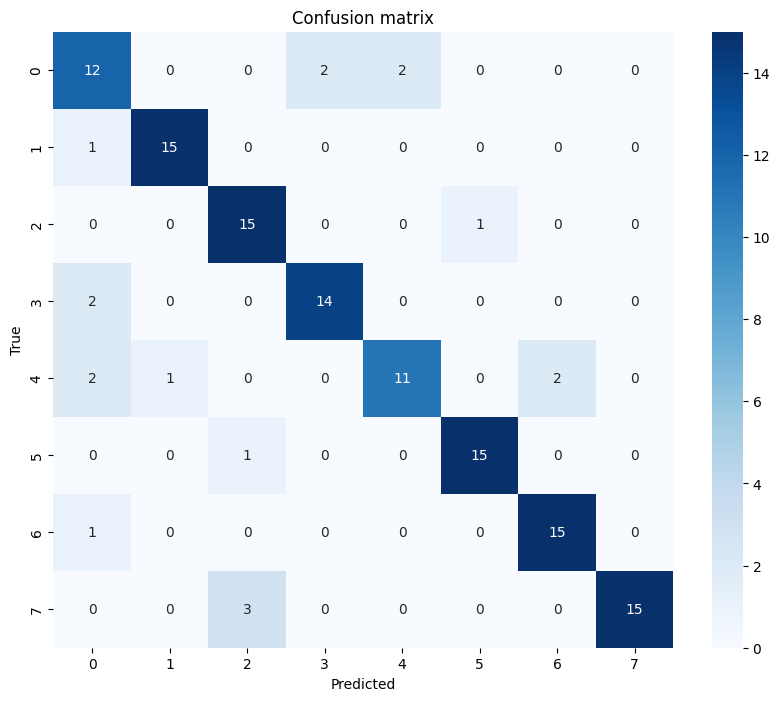

In [18]:
test(model, dataloaders['test'], criterion, device)